## Prelims

In [ ]:
from pathlib import Path

import mne, mne_rsa
from mne.decoding import GeneralizingEstimator, SlidingEstimator, cross_val_multiscore
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.base import clone

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.spatial.distance import squareform

%matplotlib widget

## Helpers

In [ ]:
def prepare_data(epochs, subset_str, y_col):
    data = epochs[subset_str]
    X = data.get_data(picks='mag', copy=False)
    y = data.metadata[y_col].to_list()
    return X, y

def decode(epochs, subset_str, y_col, cross_val=True):
    clf = make_pipeline(StandardScaler(), 
                        SVC(C=1, kernel='linear', decision_function_shape='ovr', probability = False))
    decoder = SlidingEstimator(clf, n_jobs=1, scoring='accuracy', verbose=True)

    X, y = prepare_data(epochs, subset_str, y_col)

    scores = cross_val_multiscore(decoder, X, y, cv=5, n_jobs=-1, verbose=False) if cross_val else decoder.fit(X, y)

    return decoder, scores

def test_decoder(decoder, epochs, subset_str, y_col):
    X, y = prepare_data(epochs, subset_str, y_col)
    scores = decoder.score(X, y)
    return scores

def plot_decoding_curves(scores, n_classes, phase, stimulus_types=None):
    # Normalize inputs to lists
    if not isinstance(scores, (list, tuple)):
        scores = [scores]
    if stimulus_types is None:
        stimulus_types = ["curve" + str(i + 1) for i in range(len(scores))]
    elif isinstance(stimulus_types, str):
        stimulus_types = [stimulus_types]

    # Define colors per stimulus type
    color_map = {"word": "blue", "image": "orange"}
    colors = [color_map.get(st, "gray") for st in stimulus_types]

    _, ax = plt.subplots(figsize=(10, 6))
    times = np.arange(-200, 1001, 4)/1000

    for score, label, color in zip(scores, stimulus_types, colors):
        if score.ndim > 1:
            mu = np.mean(score, axis=0)
            sd = np.std(score, axis=0)
            ax.plot(times, mu, label=label.capitalize(), color=color)
            ax.fill_between(times, mu - sd, mu + sd, color=color, alpha=0.2)
        else:
            ax.plot(times, score, label=label.capitalize(), color=color)

    # Chance level
    chance_level = 1.0 / n_classes
    ax.axhline(chance_level, color="k", linestyle="--",
               label=f"Chance level ({chance_level:.2f})")

    # Formatting
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Decoding performance")
    ax.set_title(f"Decoding\n{phase}")
    ax.legend()
    ax.set_ylim([0, 2 * chance_level])
    ax.axvline(0, color="k", linestyle="-", alpha=0.2)

    plt.tight_layout()
    plt.show()

## Read MEG data and metadata

In [100]:
# Define base paths and parameters
base_dir = Path("/Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline")
subject = "sub-01"
meg_dir = base_dir / subject / "meg"

# Define filenames
localizer_path = meg_dir / f"{subject}_task-localizer_epo.fif"
pushmi_path = meg_dir / f"{subject}_task-pushmi_split-01_epo.fif"

# Load epochs
localizer = mne.read_epochs(localizer_path, preload=False)
pushmi = mne.read_epochs(pushmi_path, preload=False)

localizer.metadata = pd.read_csv("metadata_localizer.csv")
pushmi.metadata = pd.read_csv("metadata_pushmi.csv")

Reading /Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-localizer_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 3 columns
960 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-pushmi_split-01_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Reading /Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-pushmi_split-01_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 20 columns
7110 matching events fo

# Localizer: Visual and semantic decoders

## Within-localizer performance

Extract the relevant words and images from the localizer task

In [50]:
# Define sets
words = ["pince", "lampe", "dinde", "biche"]
images = ["carre", "cercle", "losange", "croix"]

### Images

Loading data for 242 events and 301 original time points ...


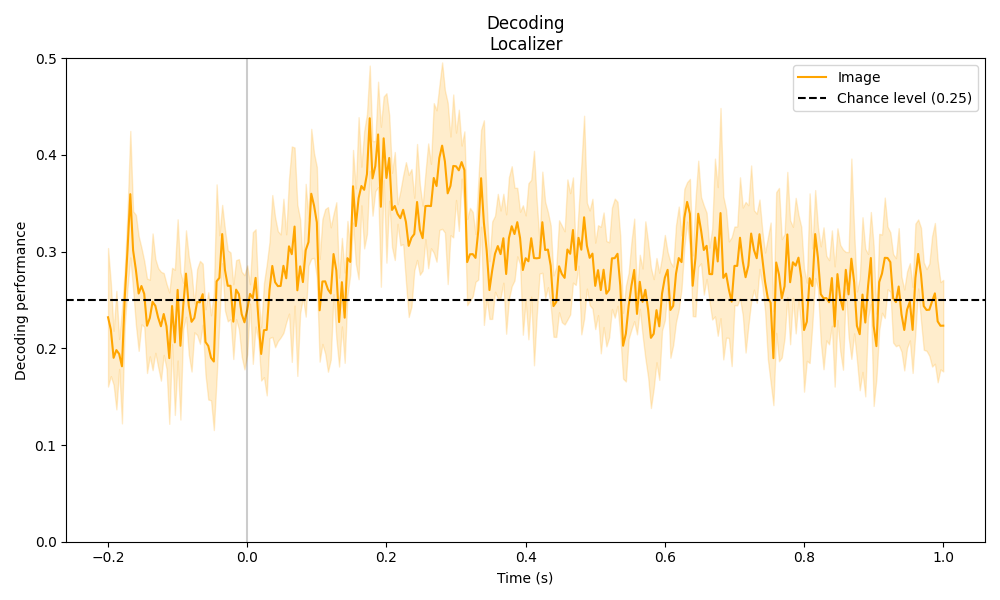

In [ ]:
_, scores_images_within = decode(localizer, f"stimulus in {images} and event_name == 'image'", 'stimulus', cross_val=True)
plot_decoding_curves(scores_images_within, n_classes=4, stimulus_types='image', phase='Localizer')

### Words: Basic-level category

Loading data for 245 events and 301 original time points ...


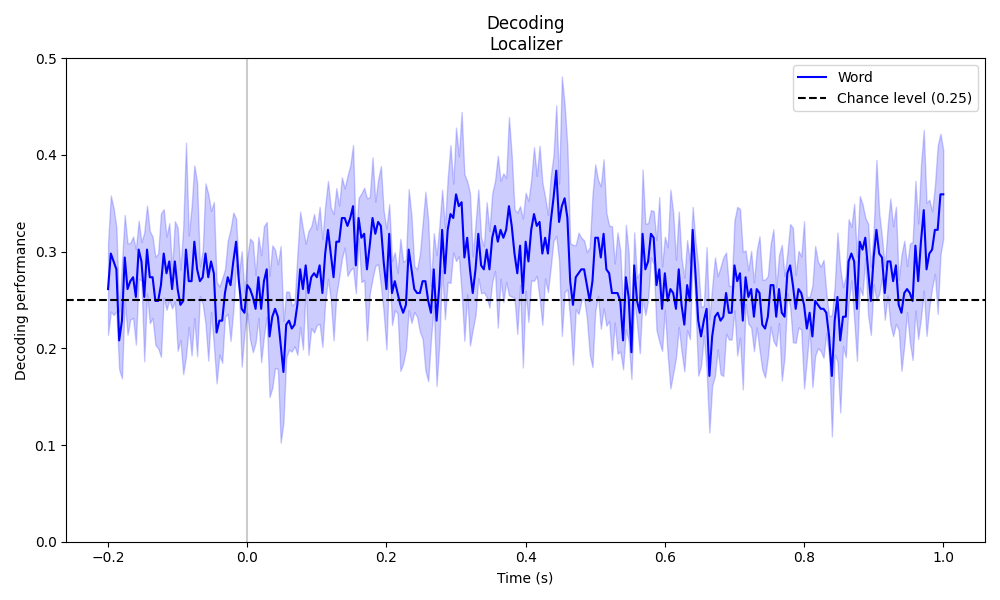

In [ ]:
_, scores_words_within = decode(localizer, f"stimulus in {words} and event_name == 'word'", 'stimulus', cross_val=True)
plot_decoding_curves(scores_words_within, n_classes=4, stimulus_types='word', phase='Localizer')

### Words: Abstract category

Loading data for 245 events and 301 original time points ...


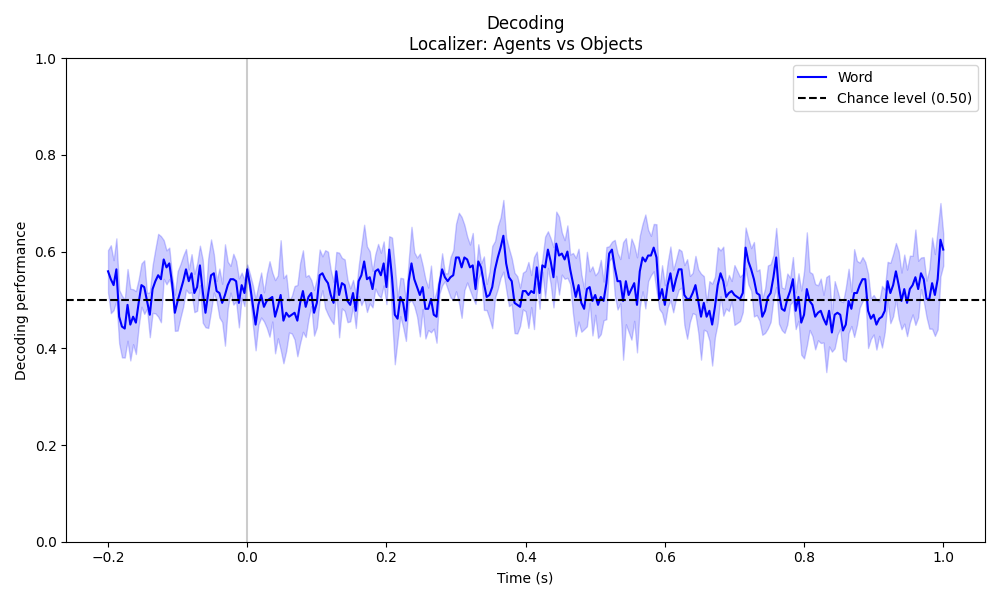

In [ ]:
_, scores_categories_within = decode(localizer, f"category in ['agent', 'object'] and event_name == 'word'", 'category', cross_val=True)
plot_decoding_curves(scores_categories_within, n_classes=2, stimulus_types='word', phase='Localizer: Agents vs Objects')

### Cross-notation decoder

In [86]:
decoder_semantic, scores_semantics = decode(localizer, f"event_name == 'word'", 'stimulus', cross_val=False)
decoder_visual, scores_visual = decode(localizer, f"event_name == 'image'", 'stimulus', cross_val=False)

Loading data for 480 events and 301 original time points ...


  0%|          | Fitting SlidingEstimator : 0/301 [00:00<?,       ?it/s]

In [88]:
semantic_to_visual_scores = test_decoder(decoder_semantic, localizer, f"event_name == 'image'", 'stimulus')
visual_to_semantic_scores = test_decoder(decoder_visual, localizer, f"event_name == 'word'", 'stimulus')

Loading data for 480 events and 301 original time points ...
Loading data for 480 events and 301 original time points ...


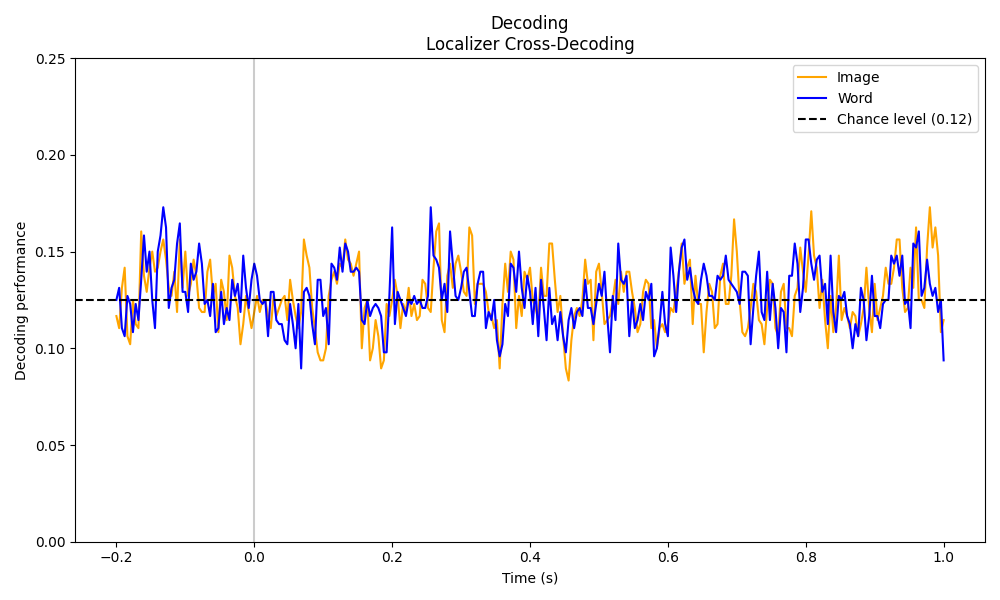

In [89]:
plot_decoding_curves([semantic_to_visual_scores, visual_to_semantic_scores], 
                     n_classes=8, 
                     stimulus_types=['image', 'word'], 
                     phase='Localizer Cross-Decoding')

### Generalization across time

In [ ]:
def gat_decoder(epochs, subset_str, y_col):
    clf = make_pipeline(StandardScaler(), 
                        SVC(C=1, kernel='linear', decision_function_shape='ovo', probability = True))
    decoder = GeneralizingEstimator(clf, n_jobs=None, verbose=True)

    X, y = prepare_data(epochs, subset_str, y_col)

    decoder.fit(X, y)

    return decoder

def test_gat(decoder, epochs, subset_str, y_col):
    X, y = prepare_data(epochs, subset_str, y_col)
    scores = decoder.score(X, y)
    return scores

def draw_gat(scores, train="words", test="images"):
    fig, ax = plt.subplots(layout="constrained")
    norm = TwoSlopeNorm(vmin=0.05, vcenter=1/8, vmax=0.2)
    im = ax.matshow(scores, norm=norm, cmap="RdBu_r", origin="lower", extent=([-0.2, 1, -0.2,  1]))

    ax.axhline(0.0, color="k")
    ax.axvline(0.0, color="k")
    ax.xaxis.set_ticks_position("bottom")
    ax.set_ylabel(f'Training: {train.capitalize()}')
    ax.set_xlabel(f'Testing: {test.capitalize()}')
    ax.set_title("Generalization across time and condition", fontweight="bold")
    fig.colorbar(im, ax=ax)
    plt.show()


In [73]:
# Words -> Images
gat_train_words = gat_decoder(localizer, f"event_name == 'word'", 'stimulus')
gat_test_images = test_gat(gat_train_words, localizer, f"event_name == 'image'", 'stimulus')

# Images -> Words
gat_train_images = gat_decoder(localizer, f"event_name == 'image'", 'stimulus')
gat_test_words = test_gat(gat_train_images, localizer, f"event_name == 'word'", 'stimulus')

Loading data for 480 events and 301 original time points ...


  0%|          | Scoring GeneralizingEstimator : 0/90601 [00:00<?,       ?it/s]

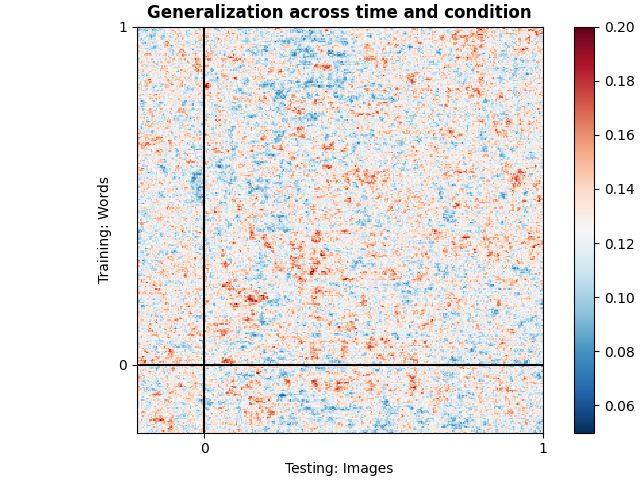

/var/folders/m9/d3b75mr14wg1v3yrwmhsc0nh0000gn/T/ipykernel_67363/2020839188.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(layout="constrained")


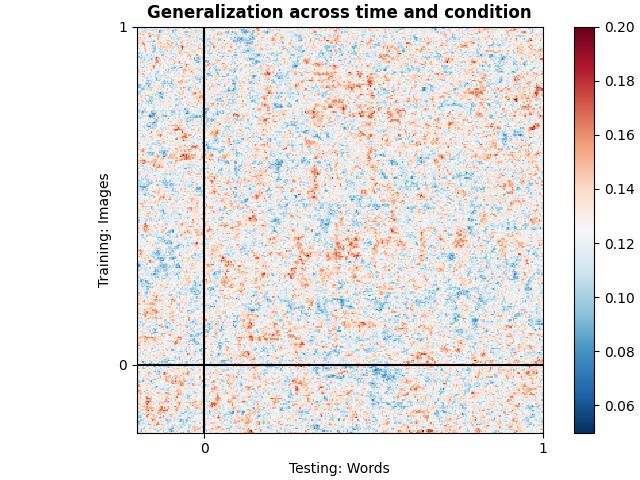

In [74]:
draw_gat(gat_test_images, train="words", test="images")
draw_gat(gat_test_words, train="images", test="words")

# Main task

## Training decoders on the localizer task

In [92]:
decoder_words, scores_words = decode(localizer, f"stimulus in {words} and event_name == 'word'", 'stimulus', cross_val=False)
decoder_images, scores_images = decode(localizer, f"stimulus in {images} and event_name == 'image'", 'stimulus', cross_val=False)

Loading data for 242 events and 301 original time points ...


  0%|          | Fitting SlidingEstimator : 0/301 [00:00<?,       ?it/s]

## Testing generalization

### Pre-assignment: Shape before word

Loading data for 274 events and 301 original time points ...


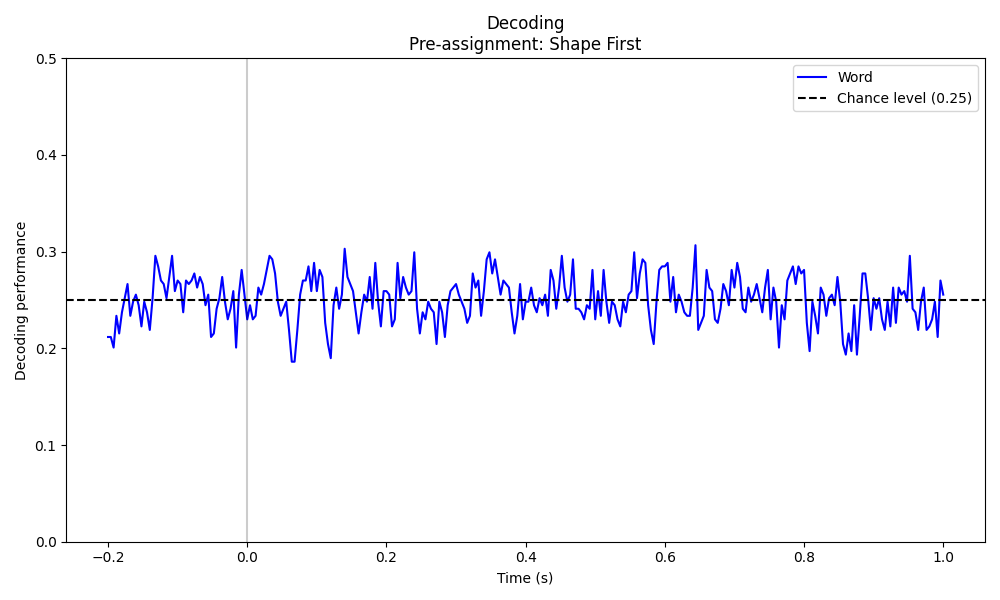

In [125]:
pre_shape_first = "event_name in ['assignment_1_shape', 'assignment_2_shape'] and assignment_order == 'symbol_first' and participant_correct"
pre_shape_first_scores = test_decoder(decoder_words, pushmi, pre_shape_first, 'assigned')
plot_decoding_curves(pre_shape_first_scores, n_classes=4, stimulus_types='word', phase='Pre-assignment: Shape First')


### Pre-assignment: Word before shape

Loading data for 285 events and 301 original time points ...


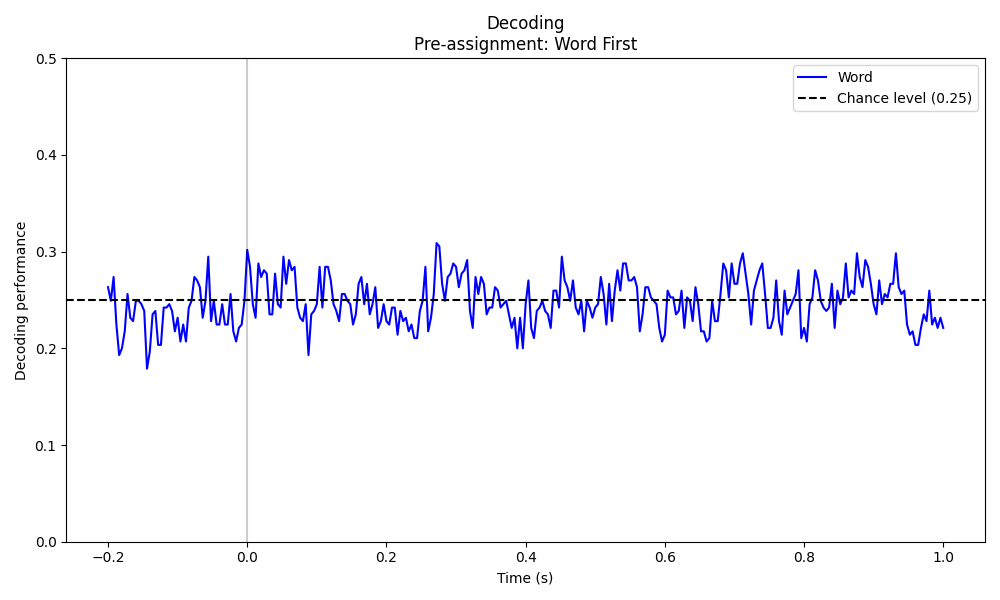

In [129]:
pre_word_first = "event_name in ['assignment_1_shape', 'assignment_2_shape'] and assignment_order == 'referent_first' and participant_correct"
pre_word_first_scores = test_decoder(decoder_words, pushmi, pre_word_first, 'assigned')
plot_decoding_curves(pre_word_first_scores, n_classes=4, stimulus_types='word', phase='Pre-assignment: Word First')

### Post-assignment

Loading data for 280 events and 301 original time points ...


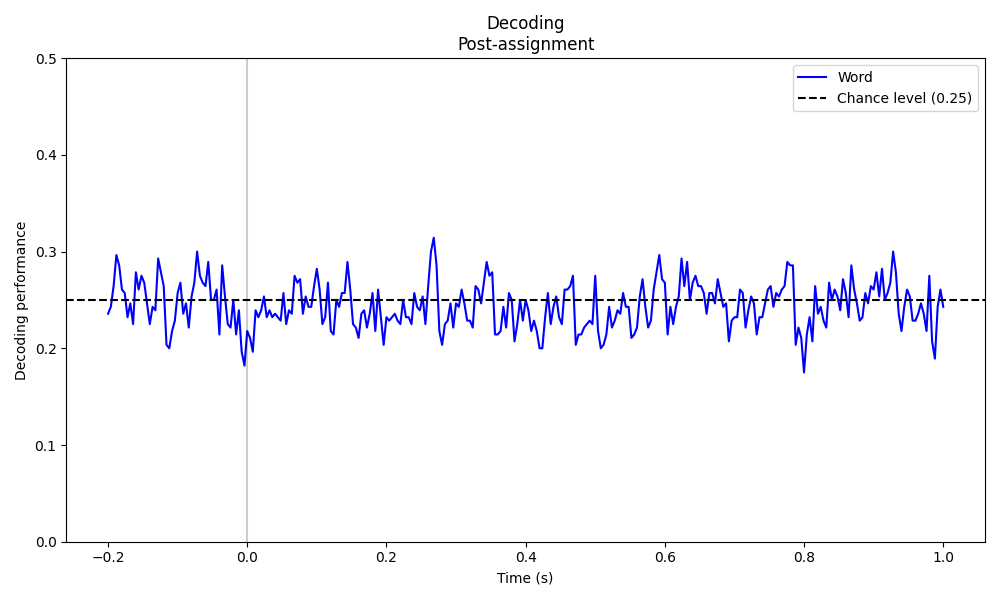

In [127]:
post = "event_name == 'central_location_flash' and participant_correct"
post_scores = test_decoder(decoder_words, pushmi, post, 'assigned')
plot_decoding_curves(post_scores, n_classes=4, stimulus_types='word', phase='Post-assignment')

## RSA

In [ ]:
# Data
epochs_central = pushmi["event_name == 'central_location_flash' and participant_correct"]
times = epochs_central.times
labels = (epochs_central.metadata["stimulus"] + "_" + epochs_central.metadata["assigned"]).tolist()

# Compute RDMs
rdm_gen = mne_rsa.rdm_epochs(
    epochs_central,
    labels=labels,
    n_folds=2,
    picks="mag",
    spatial_radius=None,
    temporal_radius=0.0,
    dist_metric="sqeuclidean"
)
rdms_over_time = list(rdm_gen)  

Loading data for 280 events and 301 original time points ...
Creating temporal searchlight patches


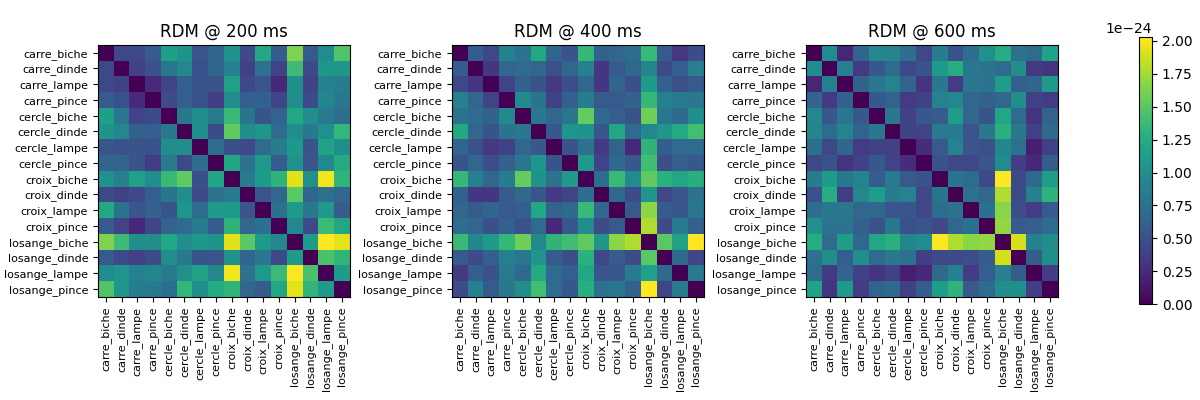

In [ ]:
def as_square(R):
    return squareform(R, checks=False) if R.ndim == 1 else R

def plot_rdms_at_times(time_points, vmax=None):
    n = len(time_points)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), constrained_layout=True)
    if n == 1:
        axes = [axes]

    # --- Determine item order ---
    uniq = np.unique(labels)
    order = sorted(uniq.tolist())  # <-- alphabetical order here

    for ax, t in zip(axes, time_points):
        i = int(np.argmin(np.abs(times - t)))
        R = as_square(rdms_over_time[i])

        # Get current label order used by mne-rsa (stable np.unique(labels)):
        cur_order = np.unique(labels)
        cur_idx_map = {lab: j for j, lab in enumerate(cur_order)}
        # Build permutation index to reorder current RDM alphabetically
        perm = [cur_idx_map[lab] for lab in order]
        R_sorted = R[np.ix_(perm, perm)]

        im = ax.imshow(R_sorted, interpolation='nearest', aspect='equal', vmin=0, vmax=vmax)
        ax.set_title(f"RDM @ {times[i]*1000:.0f} ms")
        ax.set_xticks(range(len(order)))
        ax.set_yticks(range(len(order)))
        ax.set_xticklabels(order, rotation=90, fontsize=8)
        ax.set_yticklabels(order, fontsize=8)

    fig.colorbar(im, ax=axes, shrink=0.8)
    plt.show()

# Example usage
plot_rdms_at_times([0.2, 0.4, 0.6], vmax=None)

In [246]:
np.repeat(np.arange(len(times)), FRAMES_PER_T).shape

(6020,)

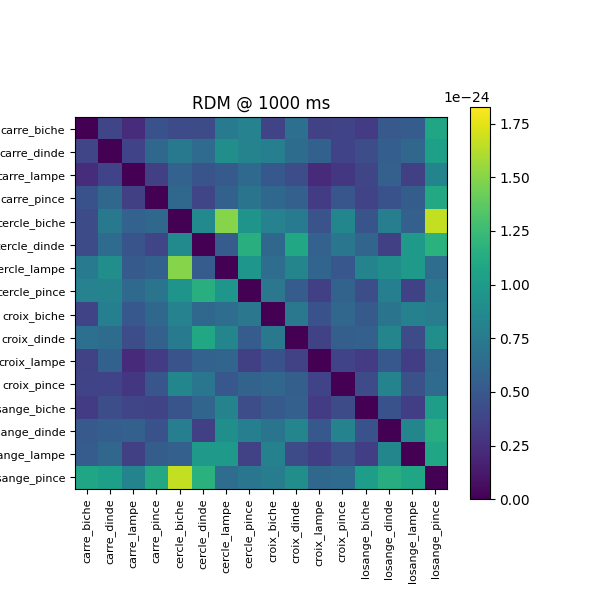

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x378a4f890>>
Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/mnepipe/lib/python3.13/site-packages/tornado/ioloop.py", line 945, in _run
    val = self.callback()
  File "/opt/homebrew/anaconda3/envs/mnepipe/lib/python3.13/site-packages/matplotlib/backend_bases.py", line 1152, in _on_timer
    ret = func(*args, **kwargs)
  File "/opt/homebrew/anaconda3/envs/mnepipe/lib/python3.13/site-packages/matplotlib/animation.py", line 1450, in _step
    still_going = super()._step(*args)
  File "/opt/homebrew/anaconda3/envs/mnepipe/lib/python3.13/site-packages/matplotlib/animation.py", line 1138, in _step
    self._draw_next_frame(framedata, self._blit)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/anaconda3/envs/mnepipe/lib/python3.13/site-packages/matplotlib/animation.py", line 1157, in _draw_next_fr

In [251]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.spatial.distance import squareform

# --- helpers you already had ---
def as_square(R):
    return squareform(R, checks=False) if getattr(R, "ndim", 2) == 1 else R

# Prepare permutation for alphabetical order
uniq_current = np.unique(labels)
cur_idx_map = {lab: i for i, lab in enumerate(uniq_current)}
order = sorted(uniq_current.tolist())
perm = np.array([cur_idx_map[lab] for lab in order])

# Precompute re-ordered RDMs
R_sorted_list = [as_square(R)[np.ix_(perm, perm)] for R in rdms_over_time]

# Color limits (stable across frames)
vmin = np.nanmin([np.nanmin(R) for R in R_sorted_list])
vmax = np.nanpercentile(np.concatenate([R.ravel() for R in R_sorted_list]), 99)

# Animation params
FRAMES_PER_T = 3
FPS = 30

# Build explicit frame id list and per-frame mapping to time index
frame_indices = np.repeat(np.arange(len(times)), FRAMES_PER_T)   # shape (N_frames,)
frames = list(range(len(frame_indices)))                         # explicit 0..N-1

# Make a fresh figure (avoid lingering timers)
plt.close('all')
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(R_sorted_list[0], interpolation='nearest', aspect='equal', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, ax=ax, shrink=0.85)
title = ax.set_title(f"RDM @ {times[0]*1000:.0f} ms")

ax.set_xticks(range(len(order))); ax.set_yticks(range(len(order)))
ax.set_xticklabels(order, rotation=90, fontsize=8)
ax.set_yticklabels(order, fontsize=8)

def update(frame):
    # Guard against any backend calling extra frames
    if frame >= len(frame_indices):
        return (im,)
    i = int(frame_indices[frame])
    im.set_data(R_sorted_list[i])
    title.set_text(f"RDM @ {times[i]*1000:.0f} ms")
    return (im,)

anim = animation.FuncAnimation(
    fig, update, frames=frames, interval=1000/FPS, blit=False, repeat=False
)

# Show inline (optional)
# from IPython.display import HTML
# HTML(anim.to_jshtml())

# Save (requires ffmpeg; or writer='pillow' for GIF)
anim.save("rdm_animation.mp4", writer="ffmpeg", fps=FPS, dpi=150)

Performing RSA between Epochs and 2 model RDM(s)
Loading data for 280 events and 301 original time points ...
    Temporal radius: 0 samples
Creating temporal searchlight patches


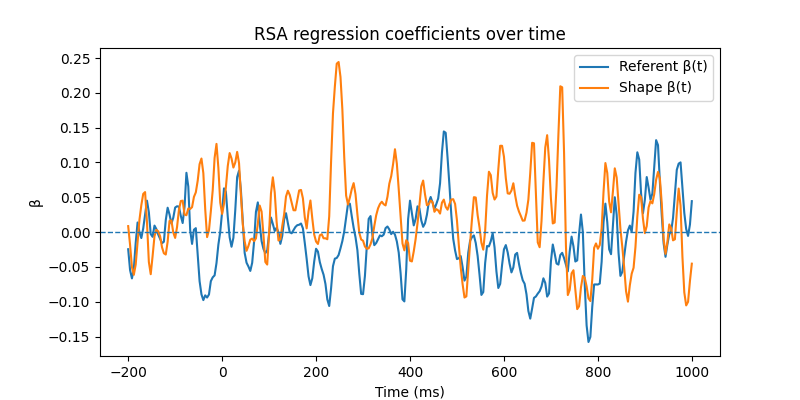

In [234]:
# --- item labels per epoch (you already have this idea) ---
labels_epochs = (epochs_central.metadata["stimulus"].astype(str) + "_" +
                 epochs_central.metadata["assigned"].astype(str)).tolist()

# Derive the unique item order used to build model RDMs:
uniq, first_idx = np.unique(labels_epochs, return_index=True)
items = uniq[np.argsort(first_idx)]  # preserves first occurrence order

# Split each item into its parts for model RDMs
stim_of_item = np.array([it.split("_", 1)[0] for it in items])
assigned_of_item = np.array([it.split("_", 1)[1] for it in items])

def categorical_rdm(groups):
    return (groups[:, None] != groups[None, :]).astype(float)

rdm_stim = categorical_rdm(stim_of_item)      # shape (n_items, n_items)
rdm_assigned = categorical_rdm(assigned_of_item)  # shape (n_items, n_items)

# --- RSA regression over time (cross-validated RDMs from data) ---
beta_evokeds = mne_rsa.rsa_epochs(
    epochs_central,
    rdm_model=[rdm_stim, rdm_assigned],
    rsa_metric="regression",
    epochs_rdm_metric="correlation",   # or "correlation"
    labels_epochs=labels_epochs,        # how trials map to items
    labels_rdm_model=items.tolist(),    # row/col labels for rdm_model
    n_folds=2,                          # CV across repeats per item
    picks="mag",
    spatial_radius=None,                # collapse sensors
    temporal_radius=0.0                 # per-time-point β
)

beta_stim, beta_assigned = beta_evokeds
t_ms   = beta_stim.times * 1000
b_stim = beta_stim.data.squeeze()
b_ass  = beta_assigned.data.squeeze()

# Quick plot
plt.figure(figsize=(8,4))
plt.plot(t_ms, b_ass,  label="Referent β(t)")
plt.plot(t_ms, b_stim, label="Shape β(t)")

plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Time (ms)"); plt.ylabel("β"); plt.legend()
plt.title("RSA regression coefficients over time"); plt.show()

Performing RSA between Epochs and 2 model RDM(s)
Loading data for 280 events and 301 original time points ...
    Temporal radius: 2 samples
Creating temporal searchlight patches


/var/folders/m9/d3b75mr14wg1v3yrwmhsc0nh0000gn/T/ipykernel_67363/879261290.py:15: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds({column: result for column, result in zip(cols, rsa_results)},


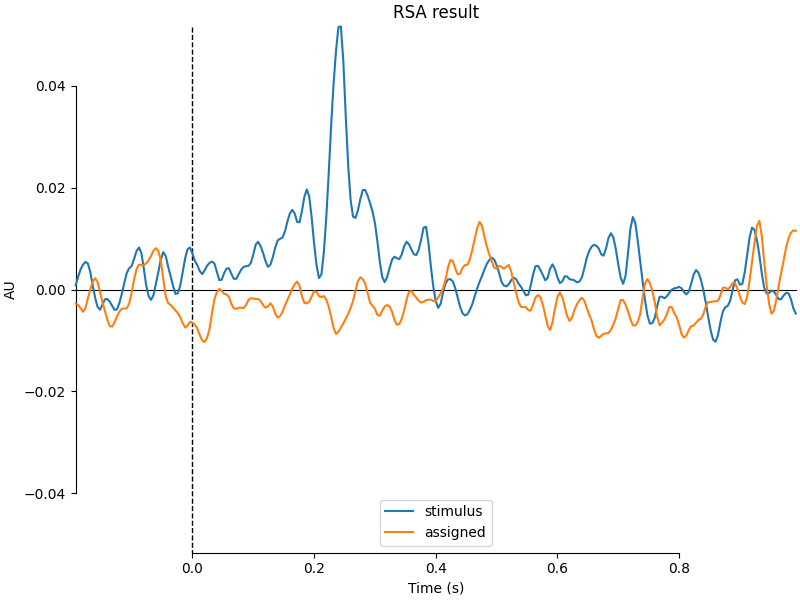

[<Figure size 800x600 with 1 Axes>]

In [241]:
cols = epochs_central.metadata.columns[4:6]
model_rdms = [categorical_rdm(epochs_central.metadata[c]) for c in cols]

n_ep = len(epochs_central)
labels_epochs = list(range(n_ep))

rsa_results = mne_rsa.rsa_epochs(
    epochs_central, model_rdms, temporal_radius=0.01,
    labels_epochs=labels_epochs)

mne.viz.plot_compare_evokeds({column: result for column, result in zip(cols, rsa_results)},
                             picks="rsa", legend="lower center", title="RSA result")